In [117]:
import os
from pathlib import Path

import pandas as pd
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt


from model_deployment.prove import Summary, StraightLineSummary

from evaluation.eval_analysis import (
    EvalDesc,
    EvalData,
    load_evals,
    find_mutual_proofs,
    PlotPoint,
    ProofPair,
    count_total_successes,
    get_two_eval_subsets,
    get_three_eval_subets,
    a_beats_b_generator,
)

In [118]:
if Path(os.curdir).resolve().name == "evaluation":
    os.chdir("../..")
elif Path(os.curdir).resolve().name == "coq-modeling": 
    pass
else:
    raise ValueError(f"In an unexpected directory: {os.curdir}")
    


In [119]:
EVALS = [
    ## Ablations on Rango
    # EvalDesc("tfidf proof; tfidf prem", "proof-prem-final"),
    # EvalDesc("tfidf proof; bm25 prem", "tfidf-proof-bm25-proj-thm-prem-final"),
    # EvalDesc("tfidf proof; select prem", "tfidf-proof-select-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),

    ## Ablations on Rango Bm25
    #EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; bm25 prem", "bm25-proof-bm25-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; select prem", "bm25-proof-select-proj-thm-prem-final"),
    # EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),

    ## First Step Retrieval 
    # EvalDesc("bm25 proof; tfidf prem", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("bm25 proof (first step); tfidf prem", "bm25-first-step-proof-tfidf-proj-thm-prem-final"),

    ## Token Masking
    # EvalDesc("No mask", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("Masked Proof State", "bm25-proof-tfidf-proj-thm-prem-final-mask-state"),
    # EvalDesc("Masked Proof Script", "bm25-proof-tfidf-proj-thm-prem-final-mask-script"),
    # EvalDesc("Masked Retrieved Proofs", "bm25-proof-tfidf-proj-thm-prem-final-mask-proof"),
    # EvalDesc("Masked Retrieved Premises", "bm25-proof-tfidf-proj-thm-prem-final-mask-premise"),

    ## Multiple runs of Select 
    # EvalDesc("tfidf proof; select prem 1", "tfidf-proof-select-proj-thm-prem-final"),
    # EvalDesc("tfidf proof; select prem 2", "tfidf-proof-select-proj-thm-prem-final-2"),
    # EvalDesc("tfidf proof; select prem 3", "tfidf-proof-select-proj-thm-prem-final-3"),

    ## Previous Proofs
    # EvalDesc("Rango", "bm25-proof-tfidf-proj-thm-prem-final"),
    # EvalDesc("Directly Trying Previous Proofs", "bm25-prev-proof-final"),

    # Random Intersect Comparison
    EvalDesc("Inter-project", "bm25-proof-tfidf-proj-thm-prem-intersect-final"),
    EvalDesc("Inter-file", "bm25-proof-tfidf-proj-thm-prem-intersect-random"),

]
RESULTS_LOC = Path("evaluations/eval-results")
raw_evals = load_evals(EVALS, RESULTS_LOC)

In [120]:
[len(r.results) for r in raw_evals]

[500, 150]

## Proof Count (Sanity Check)

In [121]:
mutual_proofs = find_mutual_proofs(raw_evals, include_errors=True)
evals = [e.filter_to_proofs(mutual_proofs) for e in raw_evals]
assert all(len(e.results) == len(mutual_proofs) for e in evals)
print("Mutual proofs:", len(mutual_proofs))

Mutual proofs: 150


In [122]:
len(mutual_proofs)

150

## Successes

In [123]:
rows: list[tuple[int, int, float]] = []
idx: list[str] = []
for e in evals:
    n_successes = len(e.get_successful_searches())
    n_attempts = len(e.results)
    p = n_successes / n_attempts
    moe = 1.96 * (p * (1 - p) / n_attempts) ** 0.5
    rows.append((n_successes, n_attempts, n_successes / n_attempts))
    idx.append(e.alias)
pd.DataFrame(rows, columns=["Successes", "Attempts", "Success Rate"], index=idx)



,Successes,Attempts,Success Rate
bm25 proof; tfidf prem,52,150,0.346667
bm25 proof (first step); tfidf prem,42,150,0.280000


In [124]:
(149 - 69) / 69

1.1594202898550725

## Count Error Fraction

In [125]:
for e in evals:
    print(e.alias, e.get_error_fraction())

bm25 proof; tfidf prem 0.006666666666666667
bm25 proof (first step); tfidf prem 0.10666666666666667


## Proofs over Time

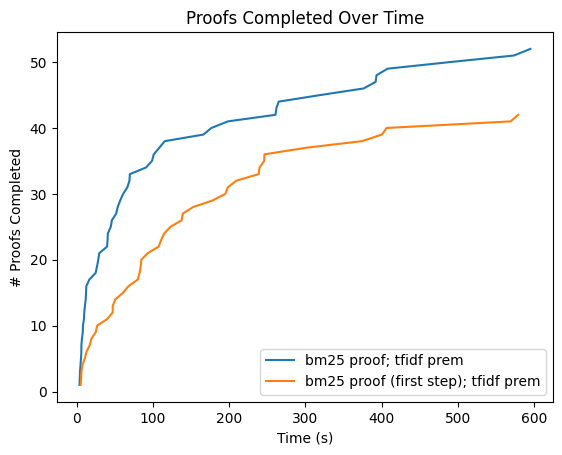

In [126]:
def plot_times(es: list[EvalData]):
    times = [e.get_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Time")
    ax.legend(loc="lower right")


plot_times(evals)

In [127]:
def get_last_success(e: EvalData) -> float:
    successes = e.get_successful_searches()
    return max(successes, key=lambda s: s.search_time).search_time

[(e.alias, get_last_success(e)) for e in evals]



[('bm25 proof; tfidf prem', 594.9780566692352),
 ('bm25 proof (first step); tfidf prem', 578.9656627178192)]

# Proofs Completed over Model Time

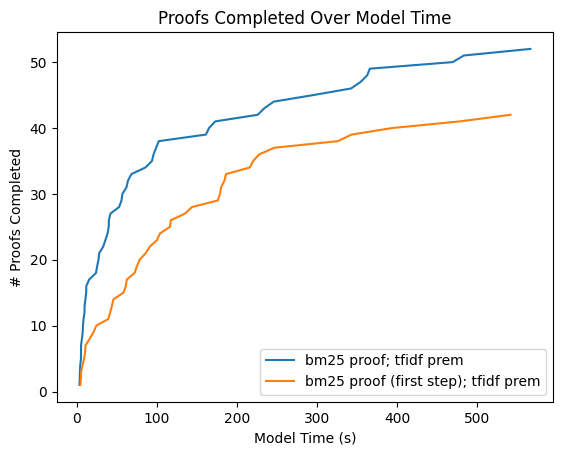

In [128]:
def plot_model_times(es: list[EvalData]):
    times = [e.get_model_time_points() for e in es]
    fig, ax = plt.subplots()
    for e, time_list in zip(es, times):
        xs = [t.x for t in time_list]
        ys = [t.y for t in time_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("Model Time (s)")
    ax.set_ylabel("# Proofs Completed")
    ax.set_title("Proofs Completed Over Model Time")
    ax.legend(loc="lower right")


plot_model_times(evals)

## Proofs over Attempts

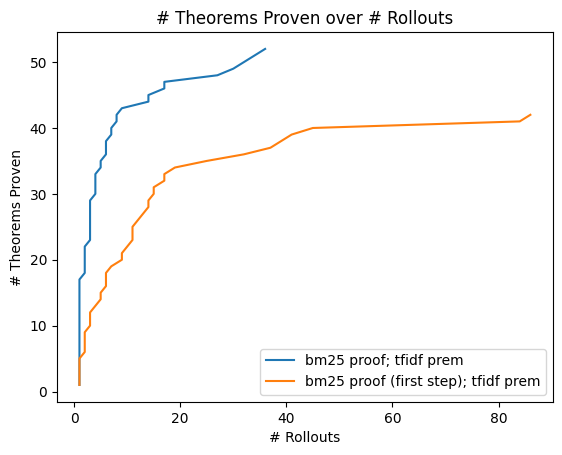

In [129]:
def plot_attempts(es: list[EvalData]):
    attempts = [e.get_attempts_points() for e in es]
    fig, ax = plt.subplots()
    for e, attempt_list in zip(es, attempts):
        xs = [t.x for t in attempt_list]
        ys = [t.y for t in attempt_list]
        ax.plot(xs, ys, label=e.alias)
    ax.set_xlabel("# Rollouts")
    ax.set_ylabel("# Theorems Proven")
    ax.set_title("# Theorems Proven over # Rollouts")
    ax.legend(loc="lower right")


plot_attempts(evals)

## Overlap Comparison

In [130]:
print("Total # Theorems Found: ", count_total_successes(evals))

Total # Theorems Found:  57


AssertionError: 

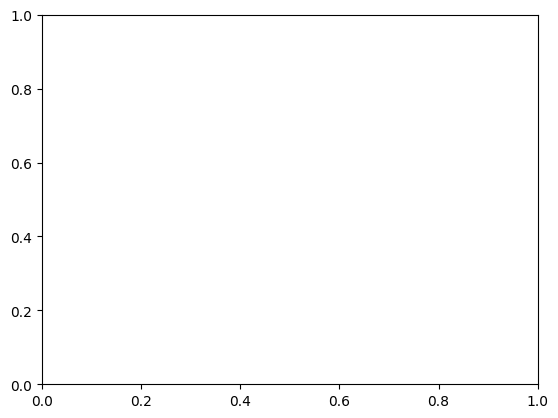

In [131]:
def compare_two(es: list[EvalData], e1_alias: str, e2_alias: str):
    fig, ax = plt.subplots()
    subsets = get_two_eval_subsets(es, e1_alias, e2_alias)
    venn2((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two)),
          set_labels=(e1_alias, e2_alias), ax=ax)


def compare_three(es: list[EvalData], e1_alias: str, e2_alias: str, e3_alias: str):
    fig, ax = plt.subplots()
    subsets = get_three_eval_subets(es, e1_alias, e2_alias, e3_alias)
    venn3((len(subsets.one_only), len(subsets.two_only), len(subsets.one_two),
              len(subsets.three_only), len(subsets.one_three), len(subsets.two_three),
              len(subsets.one_two_three)),
             set_labels=(e1_alias, e2_alias, e3_alias), ax=ax)

compare_three(evals, "Bm25 Proofs + Premises", "Proofs Bm25", "Basic")

In [ ]:
subsets = get_two_eval_subsets(evals, "Basic", "Proofs + Premises")

AssertionError: 

In [ ]:
sorted([p for p in subsets.two_only if "AbsInt" in str(p.file_name)], key= lambda p: p.file_name)

[ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/MenhirLib/Interpreter_complete.v', theorem_id='start_goto-5'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/MenhirLib/Interpreter_complete.v', theorem_id='ptd_buffer_build_from_ptl-20'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/MenhirLib/Interpreter_complete.v', theorem_id='first_stable-1'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Allocation.v', theorem_id='ge_lub_left-26'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Asmgenproof0.v', theorem_id='exec_straight_opt_right-66'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Inlining.v', theorem_id='Anon-6'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/Locations.v', theorem_id='disjoint_cons_right-13'),
 ProofPair(file_name='raw-data/coq-dataset/repos/AbsInt-CompCert/backend/RTLgenproof.v', theorem_id='transl_exprlis

# Inspect Individual Results

In [ ]:
A = "Local Basic"
B = "Slurm Basic"
better_gen = a_beats_b_generator(evals, A, B)

In [ ]:
def display_diff(p: ProofPair, e1_alias: str, e2_alias: str, s1: Summary, s2: Summary):
    print(f"{e1_alias} beat {e2_alias} on {p.theorem_name} from {p.file_name}")
    assert s1.success == True
    if isinstance(s1, StraightLineSummary):
        assert s1.attempts is not None
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds) and {len(s1.attempts)} attempts.")
    else:
        print(f">>>>> {e1_alias} found a proof in {s1.search_time} seconds ({s1.model_time} model seconds)")

    assert s1.proof is not None
    print(s1.proof)

    print()
    if s2.search_time is None:
        print(f"<<<<< {e2_alias} failed with an error.")
        return
    if isinstance(s2, StraightLineSummary):
        assert s2.attempts is not None
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds) and {len(s2.attempts)} attempts.")
        for a in s2.attempts: 
            print(a)
    else:
        print(f"<<<<< {e2_alias} failed after {s2.search_time} seconds ({s1.model_time} model seconds)")


In [ ]:
p, s1, s2 = next(better_gen)
display_diff(p, A, B, s1, s2)


AssertionError: 